In [1]:
import os
import glob
import pandas as pd
import numpy as np
import pickle as pkl
from nltk import ngrams
import random

### import data

In [2]:
lmdb_train_path = os.path.join(os.getcwd(), 'aclImdb/train')
lmdb_test_path = os.path.join(os.getcwd(), 'aclImdb/test')

In [3]:
pos_train_files = glob.glob(lmdb_train_path+'/pos/*.txt')
neg_train_files = glob.glob(lmdb_train_path+'/neg/*.txt')
pos_test_files = glob.glob(lmdb_test_path+'/pos/*.txt')
neg_test_files = glob.glob(lmdb_test_path+'/neg/*.txt')

In [4]:
def read_txt_to_list(file_path):
    list_ = []
    for name in file_path:
        try:
            with open(name) as f:
                list_.append(f.read())
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return list_

In [5]:
pos_train_list = read_txt_to_list(pos_train_files)
neg_train_list = read_txt_to_list(neg_train_files)
pos_test_list = read_txt_to_list(pos_test_files)
neg_test_list = read_txt_to_list(neg_test_files)

In [6]:
train_list = pos_train_list + neg_train_list
test_list = pos_test_list + neg_test_list
train_y_init = list(np.ones(len(pos_train_list))) + list(np.zeros(len(neg_train_list)))
test_y_init = list(np.ones(len(pos_test_list))) + list(np.zeros(len(neg_test_list)))

In [7]:
#shuffle the data
def shuffle(X, y):
    c = list(zip(X, y))
    random.shuffle(c)
    X_, y_ = zip(*c)
    return X_, y_

In [8]:
train_X_0, train_y_0 = shuffle(train_list, train_y_init)
test_X_0, test_y = shuffle(test_list, test_y_init)

In [9]:
#prepocessiong - throw away unwanted stuff: html tags
import re
def delete_tags(sent):
    clear = re.compile('<.*?>')
    clear_cont = re.sub(clear, '', sent)
    return clear_cont
def delete_tags_dataset(list_):
    ret_list = [delete_tags(sent) for sent in list_]
    return ret_list

In [10]:
train_X_1 = delete_tags_dataset(train_X_0)
test_X= delete_tags_dataset(test_X_0)

### Tokenization

In [11]:
#prepocessing - tokenization + lemmenization
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from nltk import ngrams

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
punctuations = " ".join(punctuations).split(" ") + ["-", "...", "”", "”", '--']
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.lemma_.lower().strip() for token in tokens if (token.text not in punctuations and \
                                                                 token.text not in STOP_WORDS and \
                                                                 token.lemma_ != '-PRON-')]
# def tokenize_ngram(sent, n):
#     list_tokens = tokenize(sent)
#     ng = ngrams(list_tokens, n)
#     ret_list = [x for x in ng]
#     return ret_list

def tokenize_dataset(list_token):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    for sample in list_token:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens

In [12]:
import pickle as pkl
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(train_X_1, train_y_0, test_size = 0.2, random_state = 12)
def tokenizing_all():
    print ("Tokenizing test data")
    test_data_tokens, _ = tokenize_dataset(test_X)
    pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))
    pkl.dump(test_y, open('test_y.p', 'wb'))
    
    print("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset(val_X)
    pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))
    pkl.dump(val_y, open('val_y.p', 'wb'))

    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset(train_X)
    pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
    pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))
    pkl.dump(train_y, open('train_y.p', 'wb'))

In [13]:
# tokenizing_all()

In [14]:
def read_tokenizing_data():
    test_data_tokens = pkl.load(open("test_data_tokens.p", 'rb'))
    val_data_tokens = pkl.load(open("val_data_tokens.p", 'rb'))
    train_data_tokens = pkl.load(open("train_data_tokens.p", 'rb'))
    all_train_tokens = pkl.load(open("all_train_tokens.p", 'rb'))
    train_y = pkl.load(open("train_y.p", 'rb'))
    test_y = pkl.load(open("test_y.p", 'rb'))
    val_y = pkl.load(open("val_y.p", 'rb'))
    return test_data_tokens, val_data_tokens, train_data_tokens, all_train_tokens, train_y, test_y, val_y

In [28]:
test_data_tokens, val_data_tokens, train_data_tokens, all_train_tokens, train_y, test_y, val_y = read_tokenizing_data()

### n-gram

In [15]:
def n_gram_token(data_tokens, n):
    ng = ngrams(data_tokens, n)
    ret_list = [x for x in ng]
    return ret_list
def n_gram_token_lists(data_tokens, n):
    ret_list = []
    for one_list in data_tokens:
        ng = ngrams(one_list, n)
        ret_list.append([x for x in ng])
    return ret_list

In [16]:
def num_gram(test_data_tokens, val_data_tokens, train_data_tokens, all_train_tokens, n=2):
    test_data_2g = n_gram_token_lists(test_data_tokens, n)
    val_data_2g = n_gram_token_lists(val_data_tokens, n)
    train_data_2g = n_gram_token_lists(train_data_tokens, n)
    all_data_2g = n_gram_token(all_train_tokens, n)
    return test_data_2g, val_data_2g, train_data_2g, all_data_2g

In [300]:
test_data_ng, val_data_ng, train_data_ng, all_data_ng = num_gram(test_data_tokens, val_data_tokens, train_data_tokens, all_train_tokens, 3)

In [17]:
from collections import Counter

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_data_ng)

In [152]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 1674 ; token ('some', 'scene')
Token ('some', 'scene'); token id 1674


In [18]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_ng, token2id)
val_data_indices = token2index_dataset(val_data_ng, token2id)
test_data_indices = token2index_dataset(test_data_ng, token2id)

In [19]:
max_sentence_length = 200
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:max_sentence_length]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_sentence_length-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_y)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#baseline model
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super().__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)   #2 is the number of classification
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data.long())
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        # return logits
        out = self.linear(out.float())
        return out

class NGramModel(nn.Module):
    """
    N -gram classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super().__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear1 = nn.Linear(emb_dim, 128)
        self.linear2 = nn.Linear(128, 2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        emb = self.embed(data.long())
        out = torch.sum(emb, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        out = F.relu(self.linear1(out))
        out = self.linear2(out.float())
        return out

In [258]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
# model = NGramModel(len(id2token), emb_dim)
learning_rate = 0.02
num_epochs = 10
loss_function = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer2 = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [22]:
def running_model(num_epochs, optimizer, loss_function, show_process = 1):
    val_acc_list = []
    train_acc_list = []
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = loss_function(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_list.append(val_acc)
                train_acc = test_model(train_loader, model)
                train_acc_list.append(train_acc)
                if show_process:
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc:{}'.format( 
                               epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc)) 
    test_acc = test_model(test_loader, model)
    print ("After training for {} epochs".format(num_epochs))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_acc))
    return val_acc_list, train_acc_list, test_acc

In [23]:
def train_val_visual(train, val, title_name):
    plt.figure(figsize=(15, 10))
    plt.plot(range(len(train)), train, label = 'train accuracy')
    plt.plot(range(len(val)), val, label = 'valuation accuracy')
    plt.title(title_name)
    plt.legend()
    plt.show()

In [259]:
val_acc_list_ng_adam, train_acc_list_ng_adam, test_acc_ng_adam = running_model(10, optimizer1, loss_function)

Epoch: [1/10], Step: [101/625], Validation Acc: 72.5, Train Acc:74.135
Epoch: [1/10], Step: [201/625], Validation Acc: 76.68, Train Acc:80.19
Epoch: [1/10], Step: [301/625], Validation Acc: 79.0, Train Acc:84.795
Epoch: [1/10], Step: [401/625], Validation Acc: 80.08, Train Acc:86.945
Epoch: [1/10], Step: [501/625], Validation Acc: 78.2, Train Acc:85.865
Epoch: [1/10], Step: [601/625], Validation Acc: 78.8, Train Acc:86.33
Epoch: [2/10], Step: [101/625], Validation Acc: 79.86, Train Acc:88.835
Epoch: [2/10], Step: [201/625], Validation Acc: 81.06, Train Acc:91.005
Epoch: [2/10], Step: [301/625], Validation Acc: 80.0, Train Acc:89.745
Epoch: [2/10], Step: [401/625], Validation Acc: 79.4, Train Acc:90.845
Epoch: [2/10], Step: [501/625], Validation Acc: 80.28, Train Acc:92.845
Epoch: [2/10], Step: [601/625], Validation Acc: 79.42, Train Acc:92.895
Epoch: [3/10], Step: [101/625], Validation Acc: 79.84, Train Acc:93.745
Epoch: [3/10], Step: [201/625], Validation Acc: 80.28, Train Acc:93.29
E

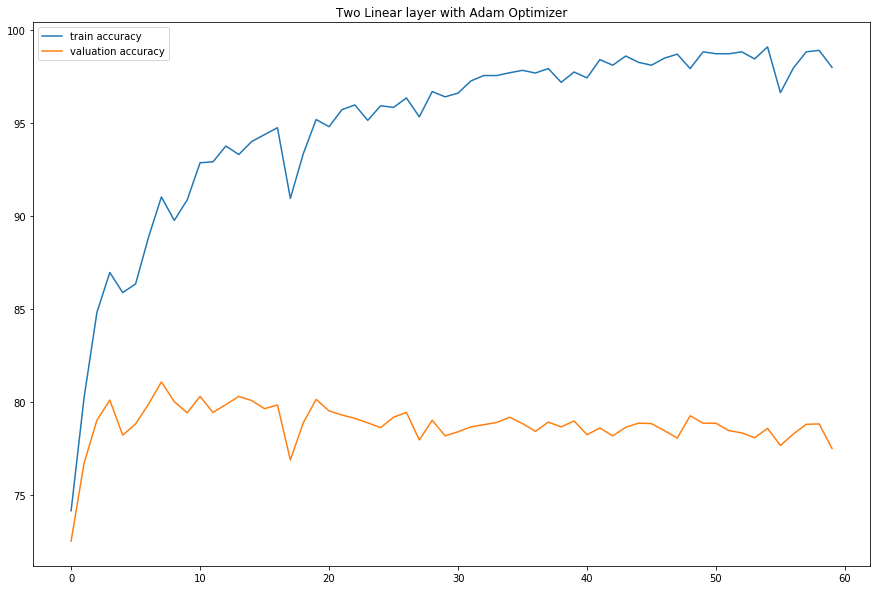

In [261]:
train_val_visual(train = train_acc_list_ng_adam, val = val_acc_list_ng_adam, title_name = 'Two Linear layer with Adam Optimizer')

In [248]:
val_acc_list_bow, train_acc_list_bow, test_acc_bow = running_model(10, optimizer1, loss_function)

Epoch: [1/10], Step: [101/625], Validation Acc: 74.38, Train Acc:77.07
Epoch: [1/10], Step: [201/625], Validation Acc: 76.86, Train Acc:81.455
Epoch: [1/10], Step: [301/625], Validation Acc: 78.54, Train Acc:83.91
Epoch: [1/10], Step: [401/625], Validation Acc: 80.6, Train Acc:87.875
Epoch: [1/10], Step: [501/625], Validation Acc: 80.5, Train Acc:88.055
Epoch: [1/10], Step: [601/625], Validation Acc: 80.28, Train Acc:88.785
Epoch: [2/10], Step: [101/625], Validation Acc: 81.28, Train Acc:90.17
Epoch: [2/10], Step: [201/625], Validation Acc: 80.62, Train Acc:90.94
Epoch: [2/10], Step: [301/625], Validation Acc: 80.78, Train Acc:91.67
Epoch: [2/10], Step: [401/625], Validation Acc: 79.96, Train Acc:91.575
Epoch: [2/10], Step: [501/625], Validation Acc: 80.34, Train Acc:92.605
Epoch: [2/10], Step: [601/625], Validation Acc: 80.56, Train Acc:93.585
Epoch: [3/10], Step: [101/625], Validation Acc: 78.94, Train Acc:91.48
Epoch: [3/10], Step: [201/625], Validation Acc: 79.68, Train Acc:93.6
Ep

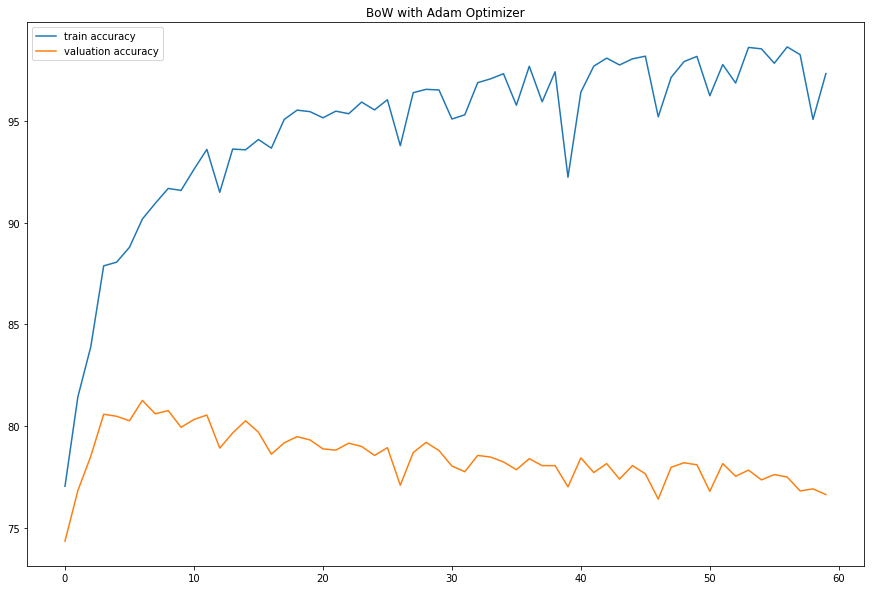

In [254]:
train_val_visual(train = train_acc_list_bow, val = val_acc_list_bow, title_name = 'BoW with Adam Optimizer')

In [240]:
val_acc_list_bow_sgd, train_acc_list_bow_sgd, test_acc_bow_sgd = running_model(10, optimizer2, loss_function)

Epoch: [1/10], Step: [101/625], Validation Acc: 52.6, Train Acc:52.815
Epoch: [1/10], Step: [201/625], Validation Acc: 57.44, Train Acc:57.67
Epoch: [1/10], Step: [301/625], Validation Acc: 55.0, Train Acc:55.115
Epoch: [1/10], Step: [401/625], Validation Acc: 50.04, Train Acc:50.095
Epoch: [1/10], Step: [501/625], Validation Acc: 56.48, Train Acc:57.57
Epoch: [1/10], Step: [601/625], Validation Acc: 57.48, Train Acc:56.99
Epoch: [2/10], Step: [101/625], Validation Acc: 53.76, Train Acc:54.43
Epoch: [2/10], Step: [201/625], Validation Acc: 50.38, Train Acc:50.72
Epoch: [2/10], Step: [301/625], Validation Acc: 57.12, Train Acc:58.25
Epoch: [2/10], Step: [401/625], Validation Acc: 52.64, Train Acc:52.945
Epoch: [2/10], Step: [501/625], Validation Acc: 57.02, Train Acc:58.315
Epoch: [2/10], Step: [601/625], Validation Acc: 55.18, Train Acc:55.34
Epoch: [3/10], Step: [101/625], Validation Acc: 57.58, Train Acc:57.81
Epoch: [3/10], Step: [201/625], Validation Acc: 52.56, Train Acc:52.87
Epo

In [232]:
import matplotlib.pyplot as plt

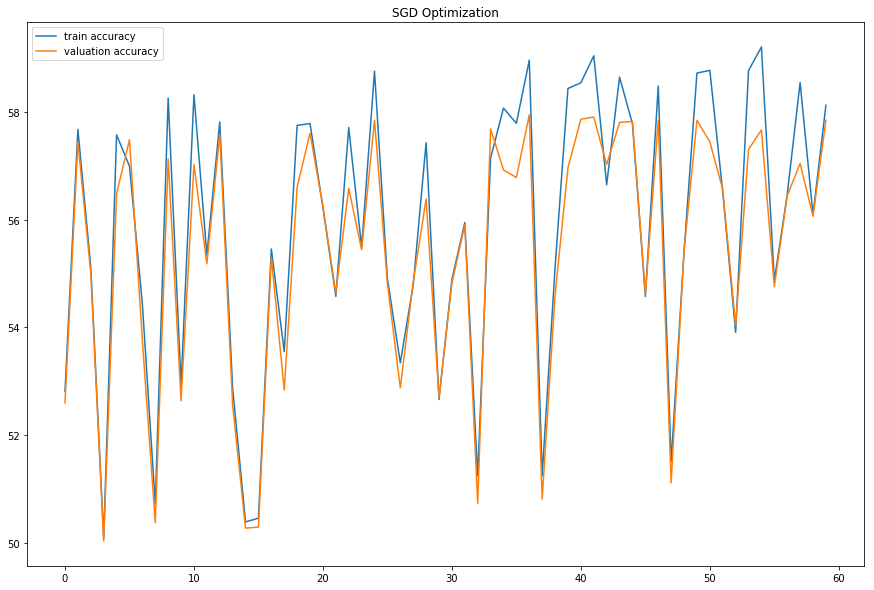

In [256]:
plt.figure(figsize=(15, 10))
plt.plot(range(len(train_acc_list_bow_sgd)), train_acc_list_bow_sgd, label = 'train accuracy')
plt.plot(range(len(val_acc_list_bow_sgd)), val_acc_list_bow_sgd, label = 'valuation accuracy')
plt.title('SGD Optimization')
plt.legend()
plt.show()

### hyperparameter tuning

In [33]:
BATCH_SIZE = 32

In [25]:
test_data_tokens, val_data_tokens, train_data_tokens, all_train_tokens, train_y, test_y, val_y = read_tokenizing_data()

In [31]:
def running_model_tune(emb_dim=100, learning_rate = 0.02, num_epochs = 2, n =2, max_vocab_size = 10000):
    test_data_ng, val_data_ng, train_data_ng, all_data_ng = num_gram(test_data_tokens, val_data_tokens, train_data_tokens, all_train_tokens, n)
    token2id, id2token = build_vocab(all_data_ng, max_vocab_size)
    val_data_indices = token2index_dataset(val_data_ng, token2id)
    train_data_indices = token2index_dataset(train_data_ng, token2id)
    test_data_indices = token2index_dataset(test_data_ng, token2id)
    
    train_dataset = NewsGroupDataset(train_data_indices, train_y)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_y)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_y)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = loss_function(outputs, label_batch)
            loss.backward()
            optimizer.step()
    test_acc = test_model(test_loader, model)
    return test_acc

- num of grams

In [36]:
n_gram_list = [1, 2, 3, 4]
test_tune_ngram = []

In [37]:
for idx in n_gram_list:
    test_val = running_model_tune(n = idx)
    test_tune_ngram.append(test_val)

In [38]:
test_tune_ngram

[84.696, 76.88, 66.212, 51.492]

- embedding dim

In [184]:
embed_dim_list = [20, 50, 75, 100, 150, 200, 500]
test_tune_embed_dim = []
for idx in embed_dim_list:
    test_val = running_model_tune(emb_dim=idx)
    test_tune_embed_dim.append(test_val)

In [187]:
test_tune_embed_dim

[78.408, 77.704, 78.636, 78.884, 79.304, 78.96, 78.812]

- learning rate

In [185]:
lr_list = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.02]
test_tune_lr = []
for idx in lr_list:
    test_val = running_model_tune(learning_rate = idx)
    test_tune_lr.append(test_val)

In [186]:
test_tune_lr

[49.912, 50.516, 54.604, 76.364, 78.788, 78.136]

- vocabulary size

In [263]:
vocab_size_list = [10000, 20000, 25000, 50000]
test_tune_vocab = []
for idx in vocab_size_list:
    test_val = running_model_tune(max_vocab_size= idx)
    test_tune_vocab.append(test_val)

In [264]:
test_tune_vocab

[76.024, 77.796, 79.204, 79.276]

### visualization

In [39]:
import matplotlib.pyplot as plt

In [40]:
def ngram_visual(list_hyper, list_test, title_name):
    plt.plot(list_hyper, list_test)
    plt.title(title_name)
    plt.show()

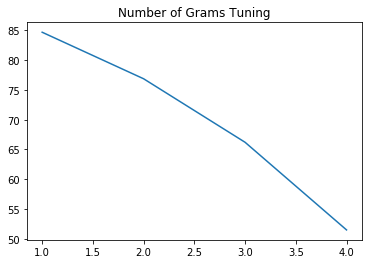

In [41]:
ngram_visual(list_hyper = n_gram_list, list_test = test_tune_ngram, title_name= 'Number of Grams Tuning')

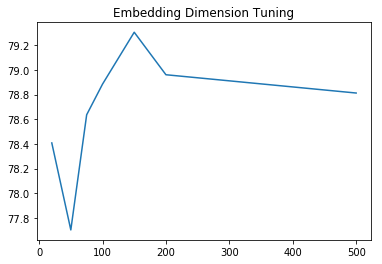

In [280]:
ngram_visual(list_hyper = embed_dim_list, list_test = test_tune_embed_dim, title_name= 'Embedding Dimension Tuning')

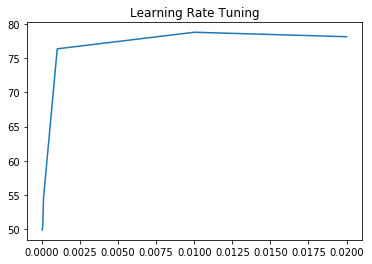

In [281]:
ngram_visual(list_hyper = lr_list, list_test = test_tune_lr, title_name= 'Learning Rate Tuning')

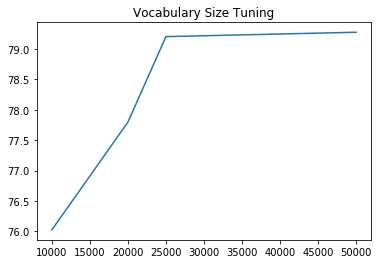

In [282]:
ngram_visual(list_hyper = vocab_size_list, list_test = test_tune_vocab, title_name= 'Vocabulary Size Tuning')

### Find the right/wrong predictions

In [62]:
def val_model_catch_pred(loader, model, id2token):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    cnt_right = 0
    cnt_wrong = 0
    wrong_list =[]
    right_list = []
    model.eval()
    for data, lengths, labels in loader:
        if cnt_right >= 3 and cnt_wrong >=3:
            break
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1] 
        equation = predicted.eq(labels.view_as(predicted)).numpy()
        for idx, cont in enumerate(equation):
            if cont==1:
                right_list.append(idx)
                cnt_right+=1
            else:
                wrong_list.append(idx)
                cnt_wrong+=1
    right_sentence_list = index2token_dataset(right_list, id2token, data_batch)
    wrong_sentence_list = index2token_dataset(wrong_list, id2token, data_batch)
    return right_sentence_list, wrong_sentence_list

In [63]:
BATCH_SIZE = 32
def running_model_tune_catch_pred(emb_dim=100, learning_rate = 0.02, num_epochs = 1, n =1, max_vocab_size = 10000):
    test_data_ng, val_data_ng, train_data_ng, all_data_ng = num_gram(test_data_tokens, val_data_tokens, train_data_tokens, all_train_tokens, n)
    token2id, id2token = build_vocab(all_data_ng, max_vocab_size)
    val_data_indices = token2index_dataset(val_data_ng, token2id)
    train_data_indices = token2index_dataset(train_data_ng, token2id)
    test_data_indices = token2index_dataset(test_data_ng, token2id)
    
    train_dataset = NewsGroupDataset(train_data_indices, train_y)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    val_dataset = NewsGroupDataset(val_data_indices, val_y)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

    test_dataset = NewsGroupDataset(test_data_indices, test_y)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = loss_function(outputs, label_batch)
            loss.backward()
            optimizer.step()
        r, w = val_model_catch_pred(val_loader, model,id2token)
    return  r, w

In [64]:
def index2token_dataset(idx, id2token, data_batch):
    sentence_list = []
    for i in list(idx):
        tokens = []
        for w in data_batch[i]:
            if id2token[w][0] != '<':
                tokens.append(id2token[w][0])
                sentence = ' '.join(tokens)
        sentence_list.append(sentence)
    return sentence_list

In [65]:
r,w = running_model_tune_catch_pred()

In [71]:
r[0]

'although comment video edit version show fire space live legend watch original show will find dialogue video edition edit find video version better scene line add want original version video version vhs offer fan original episode offer dvd another good video conquest earth scene galactica 1980 actual broadcast overall rate 10 give enjoy network want time slot give producer'

In [75]:
def similar(s1, s2):
    sameWords = set.intersection(set(s1.split(" ")), set(s2.split(" ")))
    return len(sameWords)

In [86]:
def find_original_sentence(word_list):
    similar_metric = 0
    most_similar_idx = 0
    for idx, x in enumerate(train_list):
        if similar (x, word_list) > similar_metric:
            similar_metric = similar (x, word_list)
            most_similar_idx = idx
    return train_list[most_similar_idx]

### right ones

In [87]:
find_original_sentence(r[0])

'Although others have commented that this video is just an edited version of the two shows: "Fire in Space" and "Living Legend", if you watch the original shows you\'ll find that dialogue from this video edition was edited out. I found this video version much better because scenes and lines were added to it. I would say if you want to see the show in its original version, see the video versions on VHS. They have more to offer the fan than the original episodes being offered on DVD now. Another good video is Conquest for the Earth, which had more scenes from Galactica 1980 than did the actual broadcasts themselves. Overall, I rate this as a 10 because it gives you more to enjoy than what the networks wanted to show in the time slot they gave the producers.'

In [94]:
find_original_sentence(r[3])

'This movie is the perfect illustration of how NOT to make a sci fi movie. The worst tendency in sci-fi is to make your theme an awful, sophomoric, pseudo-Orwellian/Huxleyan/whateverian "vision" of "the human future."<br /><br />Science fiction filmmakers (and authors), as geeks, take themselves very seriously given the high crap-to-good-stuff ratio of their genre. I think other genres with a high CTGSR (yes, I just made it up, relax), like horror or action or even romantic comedy, seem to have a little better grasp of the fact that they are not changing the world with some profound "message."<br /><br />Sci fi can certainly be successful on a serious level, as numerous great filmmakers have proven. But there is an immense downside to the whole concept, which is represented by "Robot Jox," with its low-rent construction of "the future" (lone good design element: the bizarre, slick-looking billboard ads all over the place that encourage women to have more babies) and its painfully heavy

In [89]:
find_original_sentence(r[2])

'In my opinion, this movie\'s title should be changed from "Only the Brave" to "All About Lane". I went to a screening of this film a few months ago and was quite disappointed with the outcome. Although, I appreciate that the director made a movie about the men of 442nd - a subject matter that long deserved addressing in the film industry - the acting in some parts of film was quite stale. The performances of Marc Dacascos, Tamlyn Tomita, and Jason Scott Lee were all great. However, the director should have NEVER put himself as the main character in the movie. Sorry Lane, you are just not a film actor. Stick to what you\'re good at - theater acting. Gina Hiraizumi\'s performance in this film was also horrible. She should never have been given a speaking role and her looks were unfit to play the part of a Miss Nisei queen. There were other young actresses in the film who were naturally beautiful and whose performances were wonderful... Why weren\'t they cast for that role? Another major

### wrong ones

In [90]:
find_original_sentence(w[0])

"Freddy's Dead: The Final Nightmare (1991) was the last film to feature Freddy Krueger as a solo act (not as an entity or a co-star). The years of killing have taken a toll upon the town of Springwood. It has gotten to the point that the little city has become a virtual ghost town. The parents who killed Freddy Krueger so many years ago have all paid the ultimate price. Only the mad inhabit the town and the survivors are scattered everywhere. But that doesn't stop Freddy from seeking out his final revenge. No matter how they try to stop him, he always comes back for more. But this time he finds out a little more about his old life. Can the kids finally stop Freddy for good? What is this secret that is buried in Freddy's twisted mind? to find out you'll have to watch Freddy's Dead. the end was originally filmed in 3-D.<br /><br />A fitting way to end the franchise. Freddy learns something about himself and his perverted life and he gets to go out in a bang! Lisa Zane, Yaphet Kotto and F

In [91]:
find_original_sentence(w[1])

'This movie was portrayed in the trailer as a comedy. It is an extreme tragedy. It left me sick to my stomach. I hated it. I think if they want to make a movie like this than they should be man enough to reflect the true intentions of the movie in the trailer. I would not have seen this movie if I would have known. I think the trailer should reflect the theme and intentions of a movie. I am tired of it. I really wanted to have a fun comedy and I am extremely disappointed. It has been several days now and I still have a bad taste in my mouth from this movie. I have never been more disappointed in a movie, nor have I ever written a comment on a bad movie. I really think that true deception was involved in this trailer because if they showed the true intention of the movie, no one would have seen it.'

In [93]:
find_original_sentence(w[2])

"If you're amused by straight-faced goings-on that are logical within a given illogical situation, you'll enjoy this whimsical 8-minute Spanish film.<br /><br />A woman enters a small café. The scene looks ordinary, but the counterman, customers, and two musicians seem somehow oddly subdued.<br /><br />Suddenly, the musicians play and one man begins to sing the title song , dancing across table tops with musical-comedy gestures. The customers, at first immobile, at intervals chime in (badly but gamely) with phrases from the song, read from slips of paper in their palms. On and off they jump up and dance (awkwardly but earnestly) in choreographed motions, like backup singers.<br /><br />But why??? the woman wonders. The answer is revealed as the soloist's jacket opens and she sees what's strapped across his chest -- just before the explosive climax...<br /><br />Even if you don't catch the song's (probably ironical) lyrics, the situation-perfect performances should give you a grin and a